## Tutorial Code
https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert

* Huh_1: refer to the Solve **Glue tasks** using BERT tutorial.
* Aha_1: a way to mensure if the model has some language skill.s
* Gotcha: GLUE (General Language Understanding Evaluation).


Why are we using open-cv if  you want to work with text

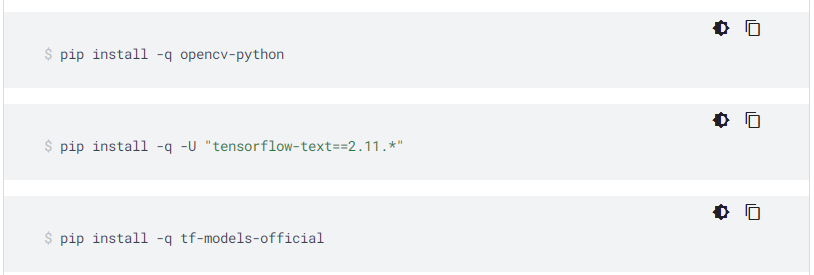

## Code

In [1]:
%%capture
## !pip install -q opencv-python # i don't understand why i need this
!pip install -q -U "tensorflow-text==2.11.*"
!pip install -q tf-models-official

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The following directory contains the BERT model's configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:



In [3]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

## Load and preprocess the dataset

* Question_1: What's CUDA.
* Aha_1: CUDA is a way to make gpu do more things than just graphics.

In [4]:
batch_size=32
glue, info = tfds.load('glue/mrpc', # it means we have two datasets?
                       with_info=True,
                       batch_size=32)

## aha: not exaclty, i think it's a specification.

In [5]:
glue

{'train': <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 'validation': <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>,
 'test': <_PrefetchDataset element_spec={'idx': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}>}

In [6]:
info.features

FeaturesDict({
    'idx': int32,
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=string),
    'sentence2': Text(shape=(), dtype=string),
})

In [7]:
info.features['label'].names

['not_equivalent', 'equivalent']

Here is one example from the training set:



In [8]:
example_batch = next(iter(glue['train']))

for key, value in example_batch.items():
  print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


## Preprocess the data

Question_1: Why different models have different tokenizers?
Aha_1: Models Like Bert Treat Text Different, So that's why we need a specific tokenizer.

In [9]:
tokenizer = tfm.nlp.layers.FastWordpieceBertTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
    lower_case=True)

Let's tokenize a test sentence:



In [10]:
tokens = tokenizer(tf.constant(["Hello TensorFlow!"]))
tokens

<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>

Learn more about the tokenization process in the [Subword tokenization](https://www.tensorflow.org/text/guide/subwords_tokenizer) and [Tokenizing with TensorFlow Text](https://www.tensorflow.org/text/guide/tokenizers) guides.


**Gotcha**: [CLS] "This is a classification problem" token, and each sentence should end with a [SEP] "Separator" token.

In [11]:
special = tokenizer.get_special_tokens_dict()
special

{'vocab_size': 30522,
 'start_of_sequence_id': 101,
 'end_of_segment_id': 102,
 'padding_id': 0,
 'mask_id': 103}

In [12]:
max_seq_length = 128

packer = tfm.nlp.layers.BertPackInputs(
    seq_length=max_seq_length,
    special_tokens_dict = tokenizer.get_special_tokens_dict())

The packer takes a list of tokenized sentences as input. For example:

In [13]:
sentences1 = ["hello tensorflow"]
tok1 = tokenizer(sentences1)
tok1

<tf.RaggedTensor [[[7592], [23435, 12314]]]>

In [14]:
sentences2 = ["goodbye tensorflow"]
tok2 = tokenizer(sentences2)
tok2

<tf.RaggedTensor [[[9119], [23435, 12314]]]>

In [15]:
packed = packer([tok1, tok2])

for key, tensor in packed.items():
  print(f"{key:15s}: {tensor[:, :12]}")

input_word_ids : [[  101  7592 23435 12314   102  9119 23435 12314   102     0     0     0]]
input_mask     : [[1 1 1 1 1 1 1 1 1 0 0 0]]
input_type_ids : [[0 0 0 0 0 1 1 1 1 0 0 0]]


## Put it all together
Combine these two parts into a keras.layers.Layer that can be attached to your model:

In [16]:
class BertInputProcessor(tf.keras.layers.Layer):
  def __init__(self, tokenizer, packer):
    super().__init__()
    self.tokenizer = tokenizer
    self.packer = packer

  def call(self, inputs):
    tok1 = self.tokenizer(inputs['sentence1'])
    tok2 = self.tokenizer(inputs['sentence2'])

    packed = self.packer([tok1, tok2])

    if 'label' in inputs:
      return packed, inputs['label']
    else:
      return packed

But for now just apply it to the dataset using Dataset.map, since the dataset you loaded from TFDS is a tf.data.Dataset object:



In [17]:
bert_inputs_processor = BertInputProcessor(tokenizer, packer)

In [18]:
glue_train = glue['train'].map(bert_inputs_processor).prefetch(1)

In [19]:
example_inputs, example_labels = next(iter(glue_train))

In [20]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [21]:
example_inputs

{'input_word_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[ 101, 1996, 7235, ...,    0,    0,    0],
        [ 101, 2625, 2084, ...,    0,    0,    0],
        [ 101, 6804, 1011, ...,    0,    0,    0],
        ...,
        [ 101, 2021, 2049, ...,    0,    0,    0],
        [ 101, 2274, 2062, ...,    0,    0,    0],
        [ 101, 2043, 1037, ...,    0,    0,    0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(32, 128), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>}

In [22]:
example_labels

<tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1])>

In [23]:
for key, value in example_inputs.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'{"labels":15s} shape: {example_labels.shape}')

input_word_ids  shape: (32, 128)
input_mask      shape: (32, 128)
input_type_ids  shape: (32, 128)
labels          shape: (32,)


In [24]:
plt.pcolormesh(example_inputs['input_word_ids'])

The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

In [25]:
plt.pcolormesh(example_inputs['input_mask'])

In [26]:
plt.pcolormesh(example_inputs['input_type_ids'])

In [27]:
glue_validation = glue['validation'].map(bert_inputs_processor).prefetch(1)
glue_test = glue['test'].map(bert_inputs_processor).prefetch(1)

I don't really understand the lines above, because i'm in a hurry. But I will not fall for perfection.

# Build the model
The first step is to download the configuration file—config_dict—for the pre-trained BERT model:

In [28]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())
config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

In [29]:
encoder_config = tfm.nlp.encoders.EncoderConfig({
    'type':'bert',
    'bert': config_dict
})

In [30]:
bert_encoder = tfm.nlp.encoders.build_encoder(encoder_config)
bert_encoder

In [31]:
bert_classifier = tfm.nlp.models.BertClassifier(network=bert_encoder, num_classes=2)
bert_classifier

In [32]:
bert_classifier(
    example_inputs, training=True).numpy()[:10]

array([[-0.00327522, -0.30776227],
       [ 0.1585139 ,  0.1802088 ],
       [-0.09675384, -0.26571167],
       [-0.27364063,  0.37604624],
       [-0.76434755,  0.04572931],
       [ 0.13050947, -0.08458461],
       [-0.31338233,  0.01231264],
       [-0.68182397,  0.35229772],
       [-0.97618127, -0.51678395],
       [ 0.031092  ,  0.35066283]], dtype=float32)

The TransformerEncoder in the center of the classifier above is the bert_encoder.

If you inspect the encoder, notice the stack of Transformer layers connected to those same three inputs:

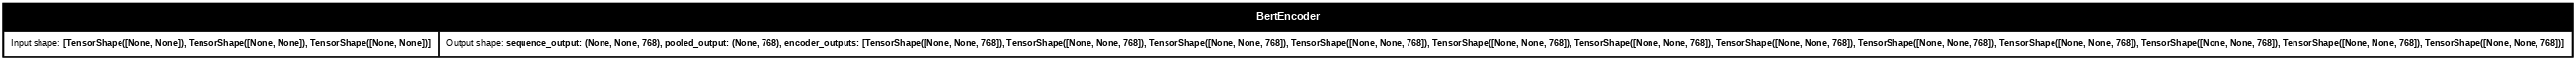

In [33]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48) # why isn't showing the map?

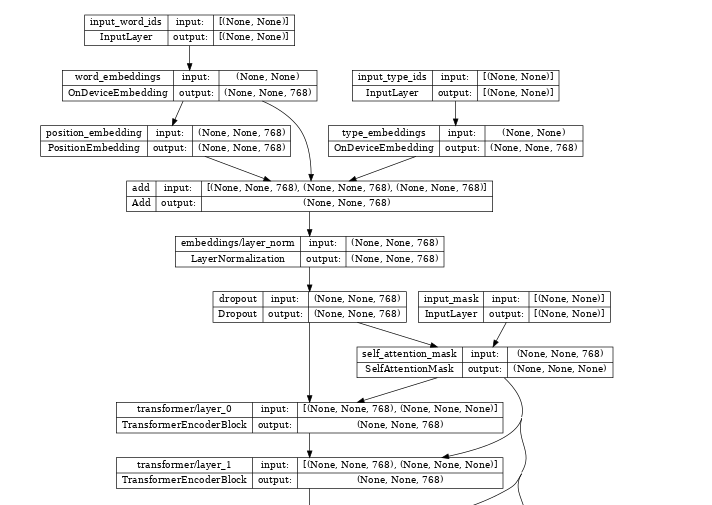

In [34]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [35]:
checkpoint = tf.train.Checkpoint(encoder=bert_encoder)
checkpoint.read(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

## Set up the optimizer

BERT typically uses the Adam optimizer with weight decay—AdamW (tf.keras.optimizers.experimental.AdamW). It also employs a learning rate schedule that first warms up from 0 and then decays to 0:

In [36]:
# Set up epochs and steps
epochs = 5
batch_size = 32
eval_batch_size = 32

train_data_size = info.splits['train'].num_examples
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate=2e-5

In [37]:
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)

In [38]:
warmup_schedule = tfm.optimization.lr_schedule.LinearWarmup(
    warmup_learning_rate = 0,
    after_warmup_lr_sched = linear_decay,
    warmup_steps = warmup_steps
)

ValueError: Attempt to convert a value (<keras.src.optimizers.schedules.learning_rate_schedule.PolynomialDecay object at 0x7d87d94d0fd0>) with an unsupported type (<class 'keras.src.optimizers.schedules.learning_rate_schedule.PolynomialDecay'>) to a Tensor.

In [39]:
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('Train step')
plt.ylabel('Learning rate')

NameError: name 'warmup_schedule' is not defined

## Train

In [41]:
optimizer = tf.keras.optimizers.experimental.Adam(
    learning_rate = warmup_schedule)

AttributeError: module 'keras._tf_keras.keras.optimizers' has no attribute 'experimental'

In [40]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

NameError: name 'optimizer' is not defined

In [42]:
bert_classifier.evaluate(glue_validation)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [43]:
bert_classifier.fit(
      glue_train,
      validation_data=(glue_validation),
      batch_size=32,
      epochs=epochs)

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [44]:
my_examples = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    }

In [45]:
ex_packed = bert_inputs_processor(my_examples)
my_logits = bert_classifier(ex_packed, training=False)

result_cls_ids = tf.argmax(my_logits)
result_cls_ids

ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: The rain in Spain falls mainly on the plain. (of type <class 'str'>)

In [46]:
tf.gather(tf.constant(info.features['label'].names), result_cls_ids)

NameError: name 'result_cls_ids' is not defined